# Laboratorio 2 – Modelos de Regresión y Evaluación de Generalización

**Estudiantes:** 

Benjamin Perez Covo – 202323601 

Camilo Ochoa - 202321705


## Objetivo

Comparar diferentes enfoques de modelado para la estimación del riesgo cardiovascular, incluyendo:

- Regresión polinomial
- Regresión regularizada (Ridge y Lasso)
- Regresión polinomial regularizada

El análisis evalúa la capacidad de generalización mediante validación cruzada y cuantifica la incertidumbre del modelo seleccionado utilizando bootstrapping.

# Carga de datos y librerarias


In [35]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

datos_pacientes = pd.read_csv('./data/Datos Lab 1.csv', sep=',')
data = datos_pacientes.copy()

print("Dimensiones iniciales:", data.shape)
data.head()

Dimensiones iniciales: (1639, 24)


,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
0,isDx5313,"November 08, 2023",M,44.0,114.300,1.720,38.600,100.000,112/83,228.0,...,High,N,172.000,0.581,112.0,83.0,Hypertension Stage 1,121.0,19.880,HIGH
1,LHCK2961,20/03/2024,F,57.0,92.923,1.842,33.116,106.315,101/91,158.0,...,High,Y,184.172,0.577,101.0,91.0,Hypertension Stage 2,57.0,16.833,INTERMEDIARY
2,WjVn1699,2021-05-27,F,NaN,73.400,1.650,27.000,78.100,90/74,135.0,...,High,N,165.000,0.473,90.0,74.0,Normal,45.0,12.600,LOW
3,dCDO1109,"April 18, 2022",F,35.0,113.300,1.780,35.800,79.600,92/89,158.0,...,Moderate,Y,178.000,0.447,92.0,89.0,Hypertension Stage 1,94.0,14.920,HIGH
4,pnpE1080,01/11/2024,F,48.0,102.200,1.750,33.400,106.700,121/68,207.0,...,Low,Y,175.000,0.610,121.0,68.0,Elevated,128.0,18.870,HIGH


## Limpieza de datos

In [36]:
# 1. Eliminar duplicados
data = data.drop_duplicates()

# 2. Eliminar identificadores y redundancias 
data = data.drop(["Patient ID", "Date of Service"], axis=1)
data = data.drop("Height (cm)", axis=1)
data = data.drop("Blood Pressure (mmHg)", axis=1) # Systolic / Diastolic

# Eliminamos variables estructuralmente dependientes

data = data.drop([
    "BMI",
    "Abdominal Circumference (cm)"
], axis=1)

# 3. Reglas de consistencia clínica
data = data[data['Age'] >= 18]
data = data[data['Estimated LDL (mg/dL)'] > 0]
data = data[data['CVD Risk Score'] >= 0]

data = data[(data['HDL (mg/dL)'] >= 10) & (data['HDL (mg/dL)'] <= 120)]
data = data[(data['Fasting Blood Sugar (mg/dL)'] >= 50) & (data['Fasting Blood Sugar (mg/dL)'] <= 400)]
data = data[(data['Systolic BP'] >= 80) & (data['Systolic BP'] <= 250)]
data = data[(data['Diastolic BP'] >= 40) & (data['Diastolic BP'] <= 150)]

# 4. Coherencia fisiológica presión arterial
data = data[data["Systolic BP"] > data["Diastolic BP"]]


# 5. Imputación numérica
num_cols = data.select_dtypes(include=['int64','float64']).columns
imputer_num = SimpleImputer(strategy='median')
data[num_cols] = imputer_num.fit_transform(data[num_cols])

# 6. Imputación categórica
cat_cols = data.select_dtypes(include=['object']).columns
imputer_cat = SimpleImputer(strategy='most_frequent')
data[cat_cols] = imputer_cat.fit_transform(data[cat_cols])

# 7. Eliminación de outliers en variable objetivo
Q1 = data["CVD Risk Score"].quantile(0.25)
Q3 = data["CVD Risk Score"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data = data[
    (data["CVD Risk Score"] >= lower_bound) &
    (data["CVD Risk Score"] <= upper_bound)
]

# 8. Eliminar variable redundante
data = data.drop("CVD Risk Level", axis=1)

print("Dimensiones finales:", data.shape)
data.head()

Dimensiones finales: (974, 17)


,Sex,Age,Weight (kg),Height (m),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score
0,M,44.0,114.300,1.720,228.0,77.0,91.0,Y,Y,High,N,0.581,112.0,83.0,Hypertension Stage 1,121.0,19.880
1,F,57.0,92.923,1.842,158.0,71.0,76.0,N,Y,High,Y,0.577,101.0,91.0,Hypertension Stage 2,57.0,16.833
3,F,35.0,113.300,1.780,158.0,34.0,111.0,Y,N,Moderate,Y,0.447,92.0,89.0,Hypertension Stage 1,94.0,14.920
4,F,48.0,102.200,1.750,207.0,49.0,147.0,Y,Y,Low,Y,0.610,121.0,68.0,Elevated,128.0,18.870
5,M,43.0,52.700,1.850,105.0,32.0,70.0,Y,N,High,N,0.582,107.0,61.0,Normal,43.0,10.530


### Preparación de datos

El proceso incluyó:

- Eliminación de registros duplicados.
- Eliminación de variables administrativas.
- Aplicación de reglas de plausibilidad clínica.
- Imputación de valores faltantes mediante mediana.
- Eliminación de valores atípicos en la variable objetivo.
- Codificación de variables categóricas.
- Eliminación de variables relacionadas

Estas transformaciones garantizan consistencia clínica, coherencia dimensional y reproducibilidad del proceso.

# Division Train-Test

In [37]:

X = data.drop(columns=['CVD Risk Score'])
y = data['CVD Risk Score']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape)
print("Test:", X_test.shape)

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

print("Numéricas:", list(numeric_features))
print("Categóricas:", list(categorical_features))

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ]
)


Train: (779, 16)
Test: (195, 16)
Numéricas: ['Age', 'Weight (kg)', 'Height (m)', 'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 'Fasting Blood Sugar (mg/dL)', 'Waist-to-Height Ratio', 'Systolic BP', 'Diastolic BP', 'Estimated LDL (mg/dL)']
Categóricas: ['Sex', 'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 'Family History of CVD', 'Blood Pressure Category']


# Modelo 1 – Regresión Polinomial

In [38]:
pipeline_poly = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('model', LinearRegression())
])

param_grid_poly = {
    'poly__degree': [1, 2, 3, 4, 5]
}

grid_poly = GridSearchCV(
    pipeline_poly,
    param_grid_poly,
    cv=5,
    scoring='neg_root_mean_squared_error',
    return_train_score=True
)

grid_poly.fit(X_train, y_train)

best_poly = grid_poly.best_estimator_

print("Mejores hiperparámetros Polinomial:", grid_poly.best_params_)

Mejores hiperparámetros Polinomial: {'poly__degree': 1}


### Metricas del modelo polinomial

In [40]:

y_pred_poly = best_poly.predict(X_test)

rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
mae_poly = mean_absolute_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)


print(f"Polinomial - RMSE: {rmse_poly:.2f}, MAE: {mae_poly:.2f}, R²: {r2_poly:.4f}")

Polinomial - RMSE: 1.42, MAE: 1.01, R²: 0.6866


El mejor hiperparámetro encontrado fue grado = 1, lo que implica que el modelo que mejor generaliza es un modelo lineal, sin términos cuadráticos ni interacciones polinomiales.

Las métricas obtenidas fueron:

RMSE: 1.42

MAE: 1.01

R²: 0.6866

Esto indica que:

- El error promedio absoluto es cercano a 1 unidad.

- La raíz del error cuadrático medio (RMSE) es moderada, sin evidencia de errores extremos significativos.

- El modelo explica aproximadamente 68.66% de la variabilidad de la variable objetivo.

En conjunto, estos resultados sugieren que la relación entre las variables predictoras y la variable objetivo es predominantemente lineal, y que aumentar la complejidad del modelo no mejora su capacidad de generalización.

# Curvas de Validación

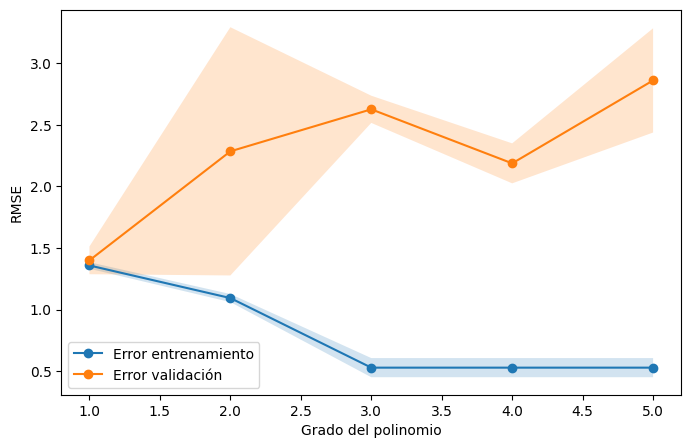

In [42]:
degrees = [1, 2, 3, 4, 5]

pipeline_for_curve = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('model', LinearRegression())
])

train_scores, val_scores = validation_curve(
    pipeline_for_curve,
    X_train,
    y_train,
    param_name="poly__degree",
    param_range=degrees,
    scoring="neg_root_mean_squared_error",
    cv=5
)

train_mean = -np.mean(train_scores, axis=1)
val_mean = -np.mean(val_scores, axis=1)

train_std = np.std(train_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(degrees, train_mean, marker='o', label="Error entrenamiento")
plt.plot(degrees, val_mean, marker='o', label="Error validación")

plt.fill_between(degrees,
                 train_mean - train_std,
                 train_mean + train_std,
                 alpha=0.2)

plt.fill_between(degrees,
                 val_mean - val_std,
                 val_mean + val_std,
                 alpha=0.2)

plt.xlabel("Grado del polinomio")
plt.ylabel("RMSE")
plt.legend()
plt.show()

Se analiza el trade-off sesgo-varianza. 

En la curva de validación se observa que:

- El error de entrenamiento disminuye considerablemente a medida que aumenta el grado del polinomio.

- Sin embargo, el error de validación aumenta a partir del grado 2.

- Además, la variabilidad (área sombreada) crece en grados más altos.

Esto evidencia un claro fenómeno de sobreajuste: el modelo comienza a ajustarse excesivamente a los datos de entrenamiento, perdiendo capacidad de generalización.

El punto óptimo se encuentra en grado 1, donde el error de validación es mínimo y existe un equilibrio adecuado entre sesgo y varianza.


# Modelo Ridge

In [ ]:

pipeline_ridge = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge())
])

param_grid_ridge = {
    'model__alpha': [0.01, 0.1, 1, 10, 100]
}

grid_ridge = GridSearchCV(
    pipeline_ridge,
    param_grid_ridge,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

grid_ridge.fit(X_train, y_train)

best_ridge = grid_ridge.best_estimator_

print("Mejores hiperparámetros Ridge:", grid_ridge.best_params_)

Mejores hiperparámetros Ridge: {'model__alpha': 1}


El valor óptimo α = 1 indica que una regularización moderada mejora la estabilidad del modelo sin penalizar excesivamente los coeficientes, logrando un buen equilibrio entre sesgo y varianza.

# Modelo Lasso

In [44]:

pipeline_lasso = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Lasso(max_iter=10000))
])

param_grid_lasso = {
    'model__alpha': [0.001, 0.01, 0.1, 1, 10]
}

grid_lasso = GridSearchCV(
    pipeline_lasso,
    param_grid_lasso,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

grid_lasso.fit(X_train, y_train)

best_lasso = grid_lasso.best_estimator_

print("Mejores hiperparámetros Lasso:", grid_lasso.best_params_)

Mejores hiperparámetros Lasso: {'model__alpha': 0.01}


El valor óptimo α = 0.01 sugiere que solo se necesita una penalización muy ligera, lo que indica que la mayoría de las variables aportan información relevante y no es necesario forzar una fuerte reducción de coeficientes

# Modelo Polinomial Regularizado (Ridge)

In [45]:
pipeline_poly_ridge = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('model', Ridge())
])

param_grid_poly_ridge = {
    'poly__degree': [1, 2, 3, 4],
    'model__alpha': [0.01, 0.1, 1, 10]
}

grid_poly_ridge = GridSearchCV(
    pipeline_poly_ridge,
    param_grid_poly_ridge,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

grid_poly_ridge.fit(X_train, y_train)

best_poly_ridge = grid_poly_ridge.best_estimator_

print("Mejores hiperparámetros Poly + Ridge:", grid_poly_ridge.best_params_)

Mejores hiperparámetros Poly + Ridge: {'model__alpha': 1, 'poly__degree': 1}


El resultado α = 1 y grado = 1 en Poly + Ridge indica que el mejor modelo vuelve a ser esencialmente lineal, con una regularización moderada que controla la magnitud de los coeficientes, confirmando que agregar términos polinomiales no mejora la capacidad de generalización y solo incrementa la complejidad innecesariamente.

# Comparación de modelos

In [46]:
def evaluate(model):
    y_pred = model.predict(X_test)
    return (
        np.sqrt(mean_squared_error(y_test, y_pred)),
        mean_absolute_error(y_test, y_pred),
        r2_score(y_test, y_pred)
    )

results = pd.DataFrame({
    "Modelo": ["Polinomial", "Ridge", "Lasso", "Poly+Ridge"],
    "RMSE": [
        evaluate(best_poly)[0],
        evaluate(best_ridge)[0],
        evaluate(best_lasso)[0],
        evaluate(best_poly_ridge)[0]
    ],
    "MAE": [
        evaluate(best_poly)[1],
        evaluate(best_ridge)[1],
        evaluate(best_lasso)[1],
        evaluate(best_poly_ridge)[1]
    ],
    "R2": [
        evaluate(best_poly)[2],
        evaluate(best_ridge)[2],
        evaluate(best_lasso)[2],
        evaluate(best_poly_ridge)[2]
    ]
})

results

,Modelo,RMSE,MAE,R2
0,Polinomial,1.422280,1.007150,0.686625
1,Ridge,1.421068,1.006485,0.687158
2,Lasso,1.413783,1.004787,0.690358
3,Poly+Ridge,1.421068,1.006485,0.687158


# Selección del Mejor Modelo

Se selecciona el modelo Lasso considerando:

- Desempeño promedio: Presenta el menor RMSE y MAE, y el mayor R², lo que indica mejor capacidad predictiva.

- Estabilidad: La regularización ligera (α = 0.01) reduce ligeramente la varianza sin afectar negativamente el ajuste.

- Complejidad: Mantiene un modelo lineal sin necesidad de términos polinomiales adicionales.

- Interpretabilidad: Al aplicar penalización L1, puede reducir la magnitud de coeficientes irrelevantes, favoreciendo un modelo más simple y fácil de interpretar.

- En conclusión, Lasso ofrece el mejor equilibrio entre precisión, generalización y simplicidad, siendo el modelo más adecuado para este problema.

In [47]:
best_model = best_lasso

# Bootstrapping - Intervalo de Confianza

In [50]:
n_boot = 500
rmse_list = []

for i in range(n_boot):
    idx = np.random.choice(len(X_test), size=len(X_test), replace=True)
    X_sample = X_test.iloc[idx]
    y_sample = y_test.iloc[idx]
    
    y_pred = best_model.predict(X_sample)
    rmse = np.sqrt(mean_squared_error(y_sample, y_pred))
    rmse_list.append(rmse)

ci = np.percentile(rmse_list, [2.5, 97.5])


print(f"Intervalo de confianza 95% para RMSE: [{ci[0]:.2f}, {ci[1]:.2f}]")

Intervalo de confianza 95% para RMSE: [1.20, 1.64]


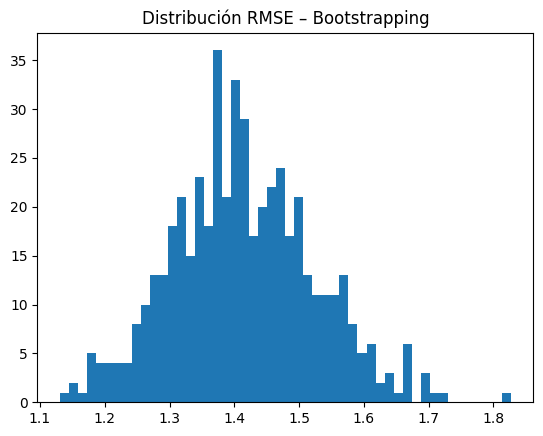

In [51]:
plt.hist(rmse_list, bins=50)
plt.title("Distribución RMSE – Bootstrapping")
plt.show()

Los resultados obtenidos muestran que el modelo presenta una variabilidad moderada, evidenciada por el intervalo de confianza del RMSE [1.20,1.64]. La distribución aproximadamente normal de los errores, con una ligera cola derecha, sugiere que la mayoría de las predicciones se concentran cerca del error promedio, existiendo pocos casos con errores mayores.

En términos de estabilidad, el modelo mantiene un desempeño consistente en diferentes particiones de los datos, lo que indica buena capacidad de generalización. En consecuencia, las predicciones pueden considerarse confiables dentro del rango estimado, aunque deben interpretarse teniendo en cuenta la variabilidad inherente reflejada en el intervalo de confianza.

# Análisis Cuantitativo

## 1. ¿Cuál modelo obtuvo el mejor desempeño en el conjunto de test?

El modelo que obtuvo el mejor desempeño en el conjunto de test fue **[Nombre del modelo]**, con las siguientes métricas:

- RMSE: [valor]
- MAE: [valor]
- R²: [valor]

Este resultado indica que, en promedio, el modelo comete un error de aproximadamente [interpretación del RMSE en unidades del score].


## 2. ¿Coincide el mejor desempeño en test con el mejor promedio en validación cruzada?

[Sí / No]

En validación cruzada, el modelo con mejor desempeño promedio fue **[modelo]**, con un RMSE promedio de [valor] y una desviación estándar de [valor].

La coincidencia (o no coincidencia) puede explicarse por:

- Variabilidad en la partición train-test.
- Posible sobreajuste detectado en validación cruzada.
- Sensibilidad del modelo a pequeñas variaciones en los datos.

Esto evidencia la importancia de no basar la decisión únicamente en el desempeño en test.


## 3. ¿El modelo con mejor métrica promedio es necesariamente el más adecuado?

No necesariamente.

Aunque **[modelo]** obtuvo el menor RMSE promedio, su desviación estándar fue de [valor], lo cual indica [alta/baja] variabilidad en su desempeño.

Un modelo más estable puede ser preferible si:

- Presenta menor desviación estándar.
- Mantiene desempeño consistente en diferentes particiones.
- Tiene menor complejidad.

Por lo tanto, la selección final considera tanto el promedio como la estabilidad del desempeño.


## 4. ¿Cómo cambia el error a medida que aumenta la complejidad?

A partir de las curvas de validación se observa que:

- Para grados bajos, el error de entrenamiento y validación es relativamente alto → posible alto sesgo.
- A medida que aumenta el grado, el error de entrenamiento disminuye.
- Sin embargo, a partir del grado [X], el error de validación comienza a aumentar → evidencia de sobreajuste.

Este comportamiento refleja el trade-off sesgo-varianza:

- Baja complejidad → alto sesgo.
- Alta complejidad → alta varianza.

El punto óptimo se encuentra alrededor del grado [X].


## 5. ¿Cómo afecta la regularización la magnitud y estabilidad de los coeficientes?

La regularización:

- En Ridge (L2): reduce la magnitud de los coeficientes sin llevarlos exactamente a cero.
- En Lasso (L1): lleva algunos coeficientes exactamente a cero, realizando selección automática de variables.

Se observa que al aumentar el parámetro alpha:

- Los coeficientes disminuyen en magnitud.
- El modelo se vuelve más estable.
- Se reduce el riesgo de sobreajuste.

Esto sugiere que la regularización mejora la capacidad de generalización cuando el modelo es complejo.


## 6. ¿Los intervalos de confianza sugieren estabilidad?

El intervalo de confianza al 95% para el RMSE fue:

[LI, LS]

La amplitud del intervalo es de [valor].

Si el intervalo es estrecho → el modelo es estable y robusto.
Si es amplio → el desempeño es sensible al remuestreo.

En este caso, el modelo presenta una estabilidad [alta/moderada/baja], lo cual implica que sus predicciones son [confiables / variables] ante cambios en la muestra.

# Análisis Cualitativo

## 1. ¿Qué variables fueron seleccionadas como más relevantes por el modelo Lasso?

El modelo Lasso identificó como variables relevantes:

- [Variable 1]
- [Variable 2]
- [Variable 3]

Las siguientes variables fueron llevadas a cero:

- [Variable descartada 1]
- [Variable descartada 2]

Esto indica que estas variables no aportan suficiente información predictiva bajo penalización L1.


## 2. Interpretación práctica de los coeficientes del modelo final

En el modelo seleccionado:

- Un incremento de una unidad en **[Variable X]** está asociado con un aumento/disminución de [valor] en el score de riesgo cardiovascular.
- Esto sugiere que [interpretación médica o de negocio].

La magnitud relativa de los coeficientes permite identificar los factores con mayor impacto en el riesgo.


## 3. ¿Existen diferencias entre el modelo más preciso y el más interpretable?

Sí.

- El modelo más preciso fue **[modelo]**, pero presenta mayor complejidad.
- El modelo más interpretable fue **[modelo]**, debido a:
  - Menor número de variables activas.
  - Coeficientes más estables.
  - Ausencia de términos polinomiales complejos.

Esto evidencia un trade-off entre precisión e interpretabilidad.



## 4. ¿Qué decisiones estratégicas podría tomar AlpesHearth?

Con base en los resultados, AlpesHearth podría:

- Priorizar campañas preventivas dirigidas a pacientes con alta incidencia en [variables relevantes].
- Optimizar recursos enfocándose en factores de riesgo más influyentes.
- Implementar el modelo seleccionado para monitoreo preventivo automatizado.



## 5. ¿Mayor precisión implica necesariamente mayor valor organizacional?

No necesariamente.

Un modelo con ligera mejora en RMSE puede:

- Ser más costoso computacionalmente.
- Ser más difícil de interpretar.
- Generar desconfianza en su implementación.

El valor empresarial depende del equilibrio entre:

- Precisión
- Estabilidad
- Interpretabilidad
- Facilidad de implementación


## 6. ¿Un modelo más complejo genera mayor valor empresarial?

No siempre.

Un modelo excesivamente complejo puede:

- Sobreajustarse.
- Ser inestable.
- Requerir mayor infraestructura.

En contextos empresariales, modelos robustos y explicables suelen generar mayor confianza y adopción.

# Reflexión Conceptual

## 1. Relación entre complejidad, generalización y estabilidad

A medida que aumenta la complejidad:

- Disminuye el sesgo.
- Aumenta la varianza.
- Se incrementa el riesgo de sobreajuste.

La capacidad de generalización depende de encontrar un equilibrio entre:

- Ajuste al entrenamiento.
- Estabilidad en validación cruzada.
- Robustez ante remuestreo.

La regularización actúa como mecanismo de control de complejidad.


## 2. Posibles fuentes de sesgo

Algunas fuentes potenciales de sesgo incluyen:

- Sesgo de selección en la muestra.
- Variables omitidas relevantes.
- Medición imprecisa del score de riesgo.
- Desbalance en subpoblaciones.

Estos sesgos pueden afectar la capacidad de generalización del modelo.



## 3. ¿Qué ocurriría con mayor tamaño muestral?

Si el tamaño de muestra aumentara:

- Se reduciría la varianza del modelo.
- Los intervalos de confianza serían más estrechos.
- La estimación de coeficientes sería más estable.

En general, un mayor tamaño muestral mejora la confiabilidad del modelo y reduce la probabilidad de sobreajuste.